<a href="https://colab.research.google.com/github/shreya12-hash/Data-Science-Machine-Learning-Artificial-Intelligence-Enthusiast/blob/master/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Satellite imagery access , analysis & visualization in Python**







## Access, preprocess, analyse and visualize satellite images  using Python.

The vast amount of satellite imagery collected every day across the globe is huge. Here we first access satellite images, analyze and visualize them in Jupyter notebooks using python.
Satellite images are pixel wised data just like any other types of images we have used. In Geography and Remote sensing terminology, this is called ***Rasters***. ***Raster images*** mainly consist of ***satellite images***, ***Lidar data*** as well as ***Georeferenced maps***. As we will see, ***rasters*** consist of a matrix of cells and row and each cell holds information about the location, such as elevation, temperature and vegetation.


Here we have done the following:
* Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
* Read and Write Raster images in Python.
* Create RGB and NDVI images from Sentinel 2 Bands

### Accessing data
Here I use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require us to access through website interaction whether directly via a downloading service utility or via the cloud.Here I access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. Then we install sentinelsat through pip.

In [0]:
pip install sentinelsat

Before I'm able to use sentinelsat, I've registered a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [0]:
from sentinelsat import SentinelAPI

user = 'shreya123' 
password = '81185555' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [0]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

All are set to use sentinelsat and download Sentinel Satellite images.Here I use data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which I've used as a boundary to clip from the whole satellite image tile. 
I have the boundary of the natural reserve as Shapefile and I've read it with Geopandas and visualize it with Folium python library.

In [0]:
!wget https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip

--2020-05-30 18:13:37--  https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ymxuxpcnj88mlz2/NReserve.zip [following]
--2020-05-30 18:13:37--  https://www.dropbox.com/s/raw/ymxuxpcnj88mlz2/NReserve.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f43ff123912325d319499764d.dl.dropboxusercontent.com/cd/0/inline/A4sNhtFtqddGRndpEteGVlbRbHmFRqUpGTfqRCoTG15_J3B6YUpR6Mo14IA2dpdCypyk2wZQOBwBhkkzOluDAfXtccDCAD21C4Szc6TjGqgyUA/file# [following]
--2020-05-30 18:13:38--  https://uc3f43ff123912325d319499764d.dl.dropboxusercontent.com/cd/0/inline/A4sNhtFtqddGRndpEteGVlbRbHmFRqUpGTfqRCoTG15_J3B6YUpR6Mo14IA2dpdCypyk2wZQOBwBhkkzOluDAfXtccDCAD21C4Szc6TjGqgyUA/file
Resolving uc3f43

In [0]:
!unzip 'NReserve.zip'

Archive:  NReserve.zip
   creating: NReserve/
 extracting: NReserve/NaturalReserve_Polygon.cpg  
  inflating: NReserve/NaturalReserve_Polygon.dbf  
  inflating: NReserve/NaturalReserve_Polygon.prj  
  inflating: NReserve/NaturalReserve_Polygon.qpj  
  inflating: NReserve/NaturalReserve_Polygon.shp  
  inflating: NReserve/NaturalReserve_Polygon.shx  


In [0]:
nReserve = gpd.read_file('NReserve/NaturalReserve_Polygon.shp')
nReserve

id                                           geometry
0  None  POLYGON ((12.34697 41.70233, 12.37470 41.71808...

With the above code, I've read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, I can add the Geopandas data to the base map I've created to visualize the Natural Reserve boundary we are interested in. Below we can see the map.

In [0]:
m = folium.Map([41.7023292727353, 12.34697305914639], zoom_start=12)
folium.GeoJson(nReserve).add_to(m)
m

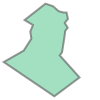

In [0]:
footprint = None
for i in nReserve['geometry']:
    footprint = i
    
footprint

Now I run a query on the api I've created above. There are different ways I can construct my query here depending on the use case. In this example, I've created a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint . For the time period, we are interested in Sentinel Level 2A satellite images taken between '20190601' and '20190626'.

In [0]:
products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

We've  got a dictionary of all products available in this period with the query specification. Here, I've received only 6 images 

In [0]:
len(products)

6

From here I can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [0]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


title  ...                                           geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...
590a4ce9-c540-4cb9-844b-3ee1efff8ca9  S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
d1a70889-1d44-414c-a357-08a7185c04b4  S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8  S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
c9e76145-3270-458c-9927-49d1354be29e  S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
3155fa67-c0d6-4c0f-a556-f5e0ee532c9d  S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...

[6 rows x 35 columns]

Here we are interested in the first satellite image since this has the least cloud coverage of all available images. So, I've simply called download and provide the product name (I can download all images at once with api.download_all() function).

In [0]:
api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

Downloading: 100%|██████████| 1.06G/1.06G [01:30<00:00, 11.7MB/s]
MD5 checksumming: 100%|██████████| 1.06G/1.06G [00:02<00:00, 460MB/s]


{'Creation Date': datetime.datetime(2019, 6, 5, 21, 55, 17, 343000),
 'Ingestion Date': datetime.datetime(2019, 6, 5, 21, 54, 46, 895000),
 'Online': True,
 'date': datetime.datetime(2019, 6, 5, 10, 0, 39, 24000),
 'downloaded_bytes': 1055191497,
 'footprint': 'POLYGON((11.354954233772318 42.39470139413761,12.687592758603905 42.42936087235922,12.723033432665233 41.441212166985935,11.410731332148327 41.407726190110715,11.354954233772318 42.39470139413761))',
 'id': '16e95baf-bbcb-43fe-ab67-5fecea2ffde5',
 'md5': 'CE4FBC92040E79591C7380F7B159B5C3',
 'path': './S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip',
 'size': 1055191497,
 'title': 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('16e95baf-bbcb-43fe-ab67-5fecea2ffde5')/$value"}

Once the download is finished, I can simply unzip it.I've used the downloaded satellite images to process, analyze and visualize them.

In [0]:
!unzip S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip

Archive:  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/INSPIRE.xml  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/star_bg.jpg  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/banner_1.png  


## Exploring Satellite Imagery with Rasterio
Once I unzip the downloaded folder, I get many subfolders and it is sometimes hard to navigate through these folders. Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution.

### Create RGB Image 
The true colour of satellite images is often displayed in a combination of red, green and blue band. So, first we read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

In [0]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'

b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')

In [0]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

In [0]:
# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

### Mask Satellite images

One important preprocessing task is to clip or mask an area of study. Since this RGB image is large and huge we have to save both computing power and time to clip and  so we use only the area of interest. We will clip the Natural reserve area from the RGB image.

In [0]:
#src = rio.open(r"RGB.tiff")
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

Here, we first reproject our Natural reserve with the same projection as the RGB image. Next, we open the RGB image, get the metadata and mask with the projected boundary.

In [0]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

#**Calculate NDVI**

Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [0]:
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b8 = rio.open(R10+'/T33TTG_20190605T100039_B08_10m.jp2')
red = b4.read()
nir = b8.read()

In [0]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)
print(ndvi)

In [0]:
ep.plot_bands(ndvi, 
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Visualization Of NDVI  ")
plt.show()

In [0]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

# **NAIP Multispectral Remote Sensing Data  access ,analysis and visualization in Python**

**What is NAIP?**

The National Agriculture Imagery Program (NAIP) acquires aerial imagery during the agricultural growing seasons in the continental U.S. A primary goal of the NAIP program is to make digital ortho photography available to governmental agencies and the public within a year of acquisition.


NAIP is a great source of high resolution imagery across the United States. NAIP imagery is often collected with just a red, green and Blue band. However, some flights include a near infrared band which is very useful for quantifying vegetation cover and health

One last step before we can search and download sentinel 2 images is to create a footprint from the nReservegeometry. Here I've used Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Now one thing if we have Geojson data, Sentinelsat provides a handy way to convert our data into a proper format in the query).

In [0]:
pip install rasterio

In [0]:
pip install geopandas 


In [0]:
pip install earthpy

# **Open NAIP Data in Python**

Next, I've used NAIP imagery for the Coldsprings fire study area in Colorado. To work with multi-band raster data we have to use the rasterio and geopandas packages. I've also used the plot module from the earthpy package for raster plotting.

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep

In [0]:
plt.rcParams['figure.figsize'] = (40, 40)
plt.rcParams['axes.titlesize'] = 30

In [0]:
data = et.data.get_data('cold-springs-fire')

In [0]:
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In order to begin, I've used the rasterio open function to open the multi-band NAIP image

rio.open("path-to-tif-file-here")

Here I've used a context manager to open raster data in Python. This ensures that the data connection is properly closed.

with rio.open("path-here") as src:

Where src is a variable name we've selected to store the raster object.

In [0]:
naip_data_path = os.path.join("data", "cold-springs-fire", 
                              "naip", "m_3910505_nw_13_1_20150919", 
                              "crop", "m_3910505_nw_13_1_20150919_crop.tif")

In [0]:
with rio.open(naip_data_path) as src:
    naip_data = src.read()
    naip_data_meta = src.meta

Above I've imported a geotiff  file which shape is a numpy array.So,clearly we've four layers in the image

In [0]:
naip_data.shape

Here we can plot a single band in the NAIP raster using imshow(). However, now that we have multiple layers or bands, so we need to tell imshow() what layer I wish to plot. So, I've used arrayname[0] to plot the first band of the image.

In [0]:
type(naip_data_meta)

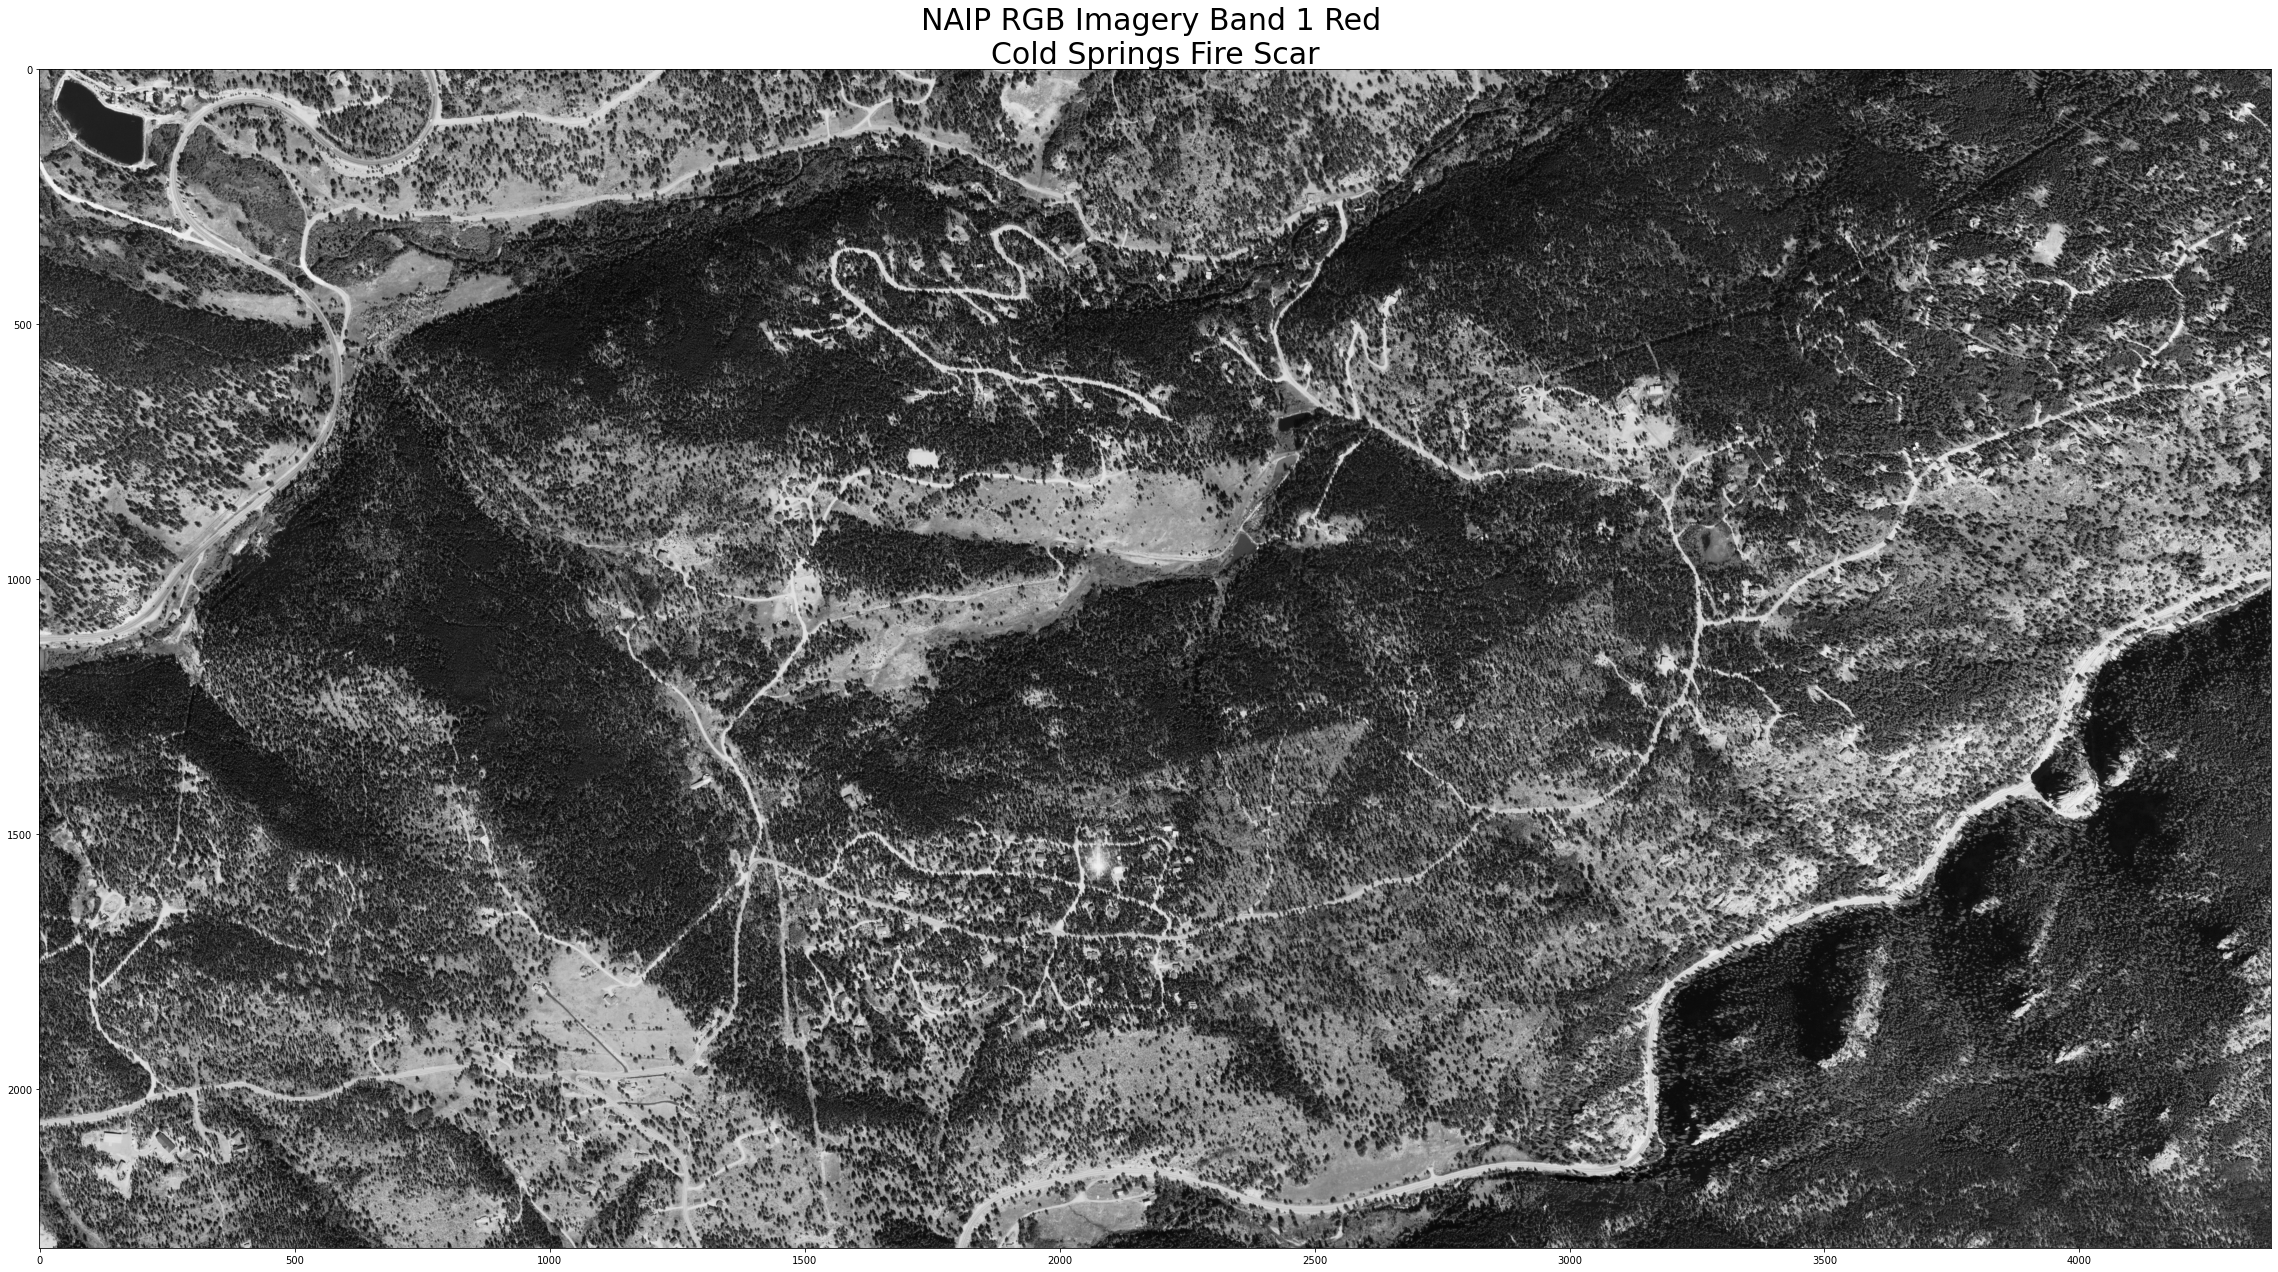

In [66]:
fig, ax = plt.subplots()

ax.imshow(naip_data[0], 
          cmap="Greys_r")

ax.set_title("NAIP RGB Imagery Band 1 Red \nCold Springs Fire Scar")

plt.show()

Or we can use the earthpy function plot_bands().we've first shown how to use earthpy to plot multiband rasters. The earthpy package was developed to make it easier to work with spatial data in Python.

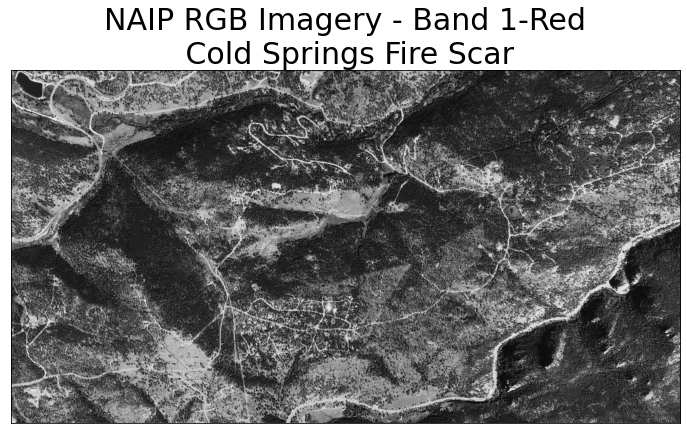

In [67]:
ep.plot_bands(naip_data[0],
              title="NAIP RGB Imagery - Band 1-Red\n Cold Springs Fire Scar",
              cbar=False)
plt.show()

If we look closely at the count element in the metadata for our raster. Note that now, the count is 4 rather than 1. This is because we have multiple bands in our raster, one for each ‘color’ or type of light collected by the camera. For NAIP data we have red, green, blue and near infrared bands. 

In [68]:
naip_data_meta

{'count': 4,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'driver': 'GTiff',
 'dtype': 'int16',
 'height': 2312,
 'nodata': -32768.0,
 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0),
 'width': 4377}

# **Image Raster Data Values**

Next, I've examined the raster’s min and max values. That is What is the value range?

In [69]:
print(naip_data.min())
print(naip_data.max())

17
242


This ***raster*** contains values between 0 and 255. These values represent degrees of brightness associated with the image band. In the case of a RGB image (red, green and blue), band 1 is the red band. When we plot the red band, larger numbers (towards 255) represent pixels with more red in them (a strong red reflection). Smaller numbers (towards 0) represent pixels with less red in them (less red was reflected).

To plot an RGB image, we mix red + green + blue values, using the ratio of each. The ratio of each color is determined by how much light was recorded (the reflectance value) in each band. This mixture creates one single color that, in turn, makes up the full color image - similar to the color image that our camera phone creates.

# **8 vs 16 Bit Images**

Here this image is an 8 bit image. This means that all values in the raster are stored within a range of 0:255. This differs from a 16-bit image, in which values can be stored within a range of 0:65,535.

Herer We've worked with 8-bit images. For 8-bit images, the brightest whites will be at or close to 255. The darkest values in each band will be closer to 0.

# **Import A Specific Band**

We can plot a single band of our choice using numpy indexing. naip_data[1] will access just the second band - which is the green band when using NAIP data and  naip_data[2] will access blue band , naip_data[3] will access near infrared band.

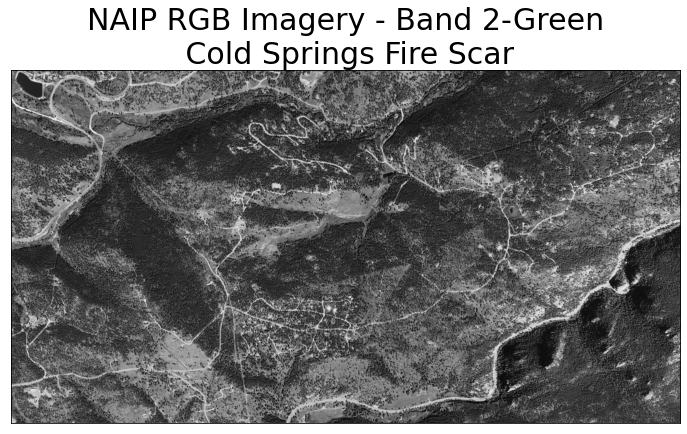

In [70]:
ep.plot_bands(naip_data[1],
              title="NAIP RGB Imagery - Band 2-Green\n Cold Springs Fire Scar",
              cbar=False)
plt.show()

In [0]:
ep.plot_bands(naip_data[2],
              title="NAIP RGB Imagery - Band 3-Blue\nCold Springs Fire Scar",
              cbar=False)
plt.show()

In [0]:
ep.plot_bands(naip_data[3],
              title="NAIP RGB Imagery - Band 4 -Near-Infrared\n Cold Springs Fire Scar",
              cbar=False)
plt.show()

# **Rasters and Numpy Arrays**

As, we've importd a raster dataset into Python, so the data are converted to a numpy array. A numpy array has no inherent spatial information attached to it and is just a matrix of values. This makes processing the data fast.

The spatial information for the raster is stored in a .meta attribute. This metadata allows us to export the data as a geotiff or other spatial format.

# **Plot Raster Band Images**

Next I've ploted each band in the raster. This is another intermediate step (like plotting histograms) that we might want to do when we first explore and open our data. Earthpy contains a plot_bands() function that allows us to quickly plot each band individually.

Similar to plotting a single band, in each band “color”, the brightest pixels are lighter in color or white representing a stronger reflectance for that color on that pixel. The darkest pixels are darker to black in color representing less reflectance of that color in that pixel.

# **Plot Bands Using Earthpy**

We use the earthpy package to plot a single or all bands in our array. To use earthpy call:

ep.plot_bands()

plot_bands() takes several key agruments including:

* arr: an n-dimensional numpy array to plot.
* figsize: a tuple of 2 values representing the x and y dimensions of the image.
* cols: if you are plotting more than one band you can specify the number of * columns in the grid that you’d like to plot.
* title: OPTIONAL - A single title for one band or a list of x titles for x bands in your array.
* cbar: OPTIONAL - ep.plot_bands() by default will add a colorbar to each plot it creates. You can turn the colobar off by setting this argument to false.

In [0]:
plt.rcParams['figure.figsize'] = (40, 40)
plt.rcParams['axes.titlesize'] = 20
titles = ["Red Band", "Green Band", "Blue Band", "Near Infrared (NIR) Band"]

# Plot all bands using the earthpy function
ep.plot_bands(naip_data, 
              figsize=(12, 5), 
              cols=2,
              title=titles,
              cbar=True)
plt.show()

# **Plot RGB Data in Python**

Previously I've plotted individual bands using a greyscale color ramp in Python. Next, I've ploted an RGB composite image. This type of image is similar in appearance to one we capture using a cell phone or digital camera.

A "true" color image consists of 3 bands - red, green and blue. When composited or rendered together in a GIS, or even a image-editor like Photoshop the bands create a color image. 

I can use the Earthpy function called plot_rgb() to quickly plot 3 band composite images. This function has several key arguments including

* arr: a numpy array in rasterio band order (bands first)
* rgb: the three bands that you wish to plot on the red, green and blue channels respectively
* title: OPTIONAL - if you want to add a title to your plot.

Similar to plotting with geopandas, we've provided an ax= argument as well to plot our data on a particular matplotlib axis.

In [0]:
ep.plot_rgb(naip_data,
            rgb=[0, 1, 2],
            title="RGB Composite image - NAIP")
plt.show()

We can plot color infared NAIP images with the title and the figure size.

In [0]:
ep.plot_rgb(naip_data, title="CIR NAIP image",
            rgb=[3, 0, 1],
            figsize=(10, 8))
plt.show()

In [0]:
ep.plot_rgb(naip_data, title=" NAIP image with band [3,0,2]",
            rgb=[3, 0, 2],
            figsize=(10, 8))
plt.show()

In order to compare grayscale plots of band 1 (red), band 2 (green) and band 4 (near infrared) whether the forested area darker or lighter in band 2 (the green band) compared to band 1 (the red band) or not, I've ploted this.

So,It is very clear that forested area darker in band 1 than band 2

In [0]:
titles = ['red', 'green', 'near\ninfrared']
ep.plot_bands(naip_data[[0, 1, 3]],
              figsize=(10,  7),
              title=titles,
              cbar=True)
plt.show()

# **Image Stretch To Increase Contrast**

The image above looks pretty good. You can explore whether applying a stretch to the image improves clarity and contrast.

When the range of pixel brightness values is closer to 0, a darker image is rendered by default. We can stretch the values to extend to the full 0-255 range of potential values to increase the visual contrast of the image.

When the range of pixel brightness values is closer to 255, a lighter image is rendered by default. We can stretch the values to extend to the full 0-255 range of potential values to increase the visual contrast of the image.

Below I've used the skimage package to contrast stretch each band in our data to make the whites more bright and the blacks more dark.

In the example below I only stretch bands 0,1 and 2 which are the RGB bands. To begin,

1. preallocate an array of zeros that is the same shape as your numpy array.
2. then look through each band in the image and rescale it.

For convenience we have also built a stretch feature into ***earthpy***. You can call it using the stretch argument.

In [0]:
band_indices = [0, 1, 2]

# Apply stretch using the earthpy plot_rgb function
ep.plot_rgb(naip_data,
            rgb=band_indices,
            title="RGB NAIP image\n Stretch Applied",
            figsize=(10, 8),
            stretch=True)
plt.show()

In this case, the stretch does increase the contrast in our image.

# **Multiband Raster Histograms**

Just like  single band rasters, we can view a histogram of each band in our data using matplotlib. Below, we loop through each band or layer in the number array and plot the distribution of reflectance values.

We can use the ep.hist() function in earthpy to plot histograms for all bands in our raster. hist() accepts several key arguments including

* arr: a numpy array in rasterio band order (bands first)
* colors: a list of colors to use for each histogram.
* title: plot titles to use for each histogram.
* cols: the number of columns for the plot grid.

In [0]:
# Create a colors and titles list to use in the histogram, then plot
colors = ['r', 'g', 'b', 'k']
titles = ['red band', 'green band', 'blue band', 'near-infrared band']

ep.hist(naip_data, 
        colors=colors, 
        title=titles, 
        cols=2)

plt.show()

In [0]:
band_indices = [3, 0, 1]

# Apply stretch using the earthpy plot_rgb function
ep.plot_rgb(naip_csf,
            rgb=band_indices,
            title="CIR NAIP image\n Stretch Applied",
            figsize=(10, 8),
            stretch=True)
plt.show()

In [0]:
ep.plot_rgb(naip_data, title=" NAIP Image with band [3,0,2]\n stretch applied",
            rgb=[3, 0, 2],
            figsize=(10, 8),
            stretch=True)
plt.show()

# **Calculate NDVI in Python**

Sometimes we can download already calculated NDVI data products from a data provider.

However, in this case, I don’t have a pre calculated NDVI product from NAIP data. I need to calculate NDVI using the NAIP imagery / reflectance data that I have downloaded from Earth Explorer.

**How to Derive the NDVI Vegetation Index From Multispectral Imagery?**

The normalized difference vegetation index (NDVI) uses a ratio between near infrared and red light within the electromagnetic spectrum. To calculate NDVI I use the following formula where NIR is near infrared light and red represents red light. For our raster data, I will take the reflectance value in the red and near infrared bands to calculate the index.

(NIR - Red) / (NIR + Red)

We can perform this calculation using matrix math with the numpy library.



Calculate NDVI using regular numpy array math. In this case, the bands we are subtracting come from the same data file. The tif file format requires that all layers are in the same CRS and of the same size so we assume the data line up. Thus we do not need to test the data for equal shape, crs and extent.

In [0]:
naip_ndvi = es.normalized_diff(naip_data[3], naip_data[0])
print(naip_ndvi)

Finally I've ploted the data. Then find the vmin= and vmax= arguments are used to stretch the colorbar across the full possible range of NDVI values (-1 to 1).

In [0]:
ep.plot_bands(naip_ndvi, 
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="NAIP Derived NDVI\n 19 September 2015 - Cold Springs Fire, Colorado")
plt.show()

Then we will view Distribution of NDVI Values
Using a histogram, we can view the distribution of pixel values in our NDVI output.

In [0]:
ep.hist(naip_ndvi,
        figsize=(12, 6),
        title=["NDVI: Distribution of pixels\n NAIP 2015 Cold Springs fire site"])

plt.show()

# **Export a Numpy Array to a Raster Geotiff in Python**


When we are done, we can export your NDVI raster data so we could use them in QGIS or ArcGIS or share them with your colleagues. To do this, you use the rio.write() function.

Exporting a raster in ***Python*** is a bit different from what we  may have learned using another language like R. In Python, you need to:

1. Create a new raster object with all of the metadata needed to define it. This metadata includes:
* the shape (rows and columns) of the object
* the coordinate reference system (crs)
* the type of file (you will export a geotiff (.tif) in this lesson
* and the type of data being stored (integer, float, etc).

Lucky for us , all of this information can be accessed from the original NAIP data that we imported into Python using attribute calls like:

***.transform*** and ***.crs***

To implement this, below we will create a rasterio object to grab the needed spatial attributes.

In [0]:
naip_data_path = os.path.join("data", "cold-springs-fire", 
                              "naip", "m_3910505_nw_13_1_20150919", 
                              "crop", "m_3910505_nw_13_1_20150919_crop.tif")

with rio.open(naip_data_path) as src:
    naip_data = src.read()
    naip_meta = src.profile

naip_meta

In [0]:
naip_transform = naip_meta["transform"]
naip_crs = naip_meta["crs"]

# View spatial attributes
naip_transform, naip_crs
#(Affine(1.0, 0.0, 457163.0, 0.0, -1.0, 4426952.0),
#CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'))

We can view the type of data stored within the ndvi array using .dtype. Here the naip_ndvi object is a numpy array

In [0]:
type(naip_ndvi), naip_ndvi.dtype

We have to use ***rio.open()*** to create a new blank raster ‘template’. Then write the NDVI numpy array to to that template using ***dst.write()***.

when we write the data we need the following elements:

1. The driver or type of file that we want to write. ‘Gtiff’ is a geotiff format
2. dtype: the structure of the data that you are writing. We are writing floating point values (values with decimal places)
3. The heigth and width of the ndvi object (accessed using the .shape attribute)
4. The crs of the spatial object (accessed using the rasterio NAIP data)
5. The transform information (accessed using the rasterio NAIP data)


Finally we need to specify the name of the output file and the path to where it will be saved on our computer.


# **Export a Numpy Array to a Raster Geotiff Using the Spatial Profile or Metadata of Another Raster**

We can use the naip_meta variable that ywe've created above. This variable contains all of the spatial metadata for naip data.

In this case, the

1. Number of bands (we have only one band vs 4 in the color image) and
2. The data format (we have floating point numbers - numers with decimals - vs integers)
have changed. Update those values then write out the image.

In [0]:
naip_meta

In [0]:
# Change the count or number of bands from 4 to 1
naip_meta['count'] = 1

# Change the data type to float rather than integer
naip_meta['dtype'] = "float64"
naip_meta

When we write the raster, we use **naip_meta.


The two ** tells Python to unpack all of the values in the naip_meta object to use as arguments when writing the geotiff file. We already updated the elements that we needed to above (count and dtype). So this naip_meta object is ready to be used for the NDVI raster.

In [0]:
naip_ndvi_outpath = os.path.join("data", "cold-springs-fire", 
                                 "outputs", "naip_ndvi.tif")

# Write your the ndvi raster object
with rio.open(naip_ndvi_outpath, 'w', **naip_meta) as dst:
    dst.write(naip_ndvi, 1)

In [0]:
naip_csf_path = os.path.join("data", "cold-springs-fire", 
                             "naip", "m_3910505_nw_13_1_20150919", 
                             "crop", "m_3910505_nw_13_1_20150919_crop.tif")

with rio.open(naip_csf_path) as src:
    naip_csf = src.read()
    naip_csf_meta = src.meta

# **Calculate and Plot  Normalized Burn Ratio (NBR) using Landsat 8 Remote Sensing Data in Python**

In [0]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import seaborn as sns
import numpy as np
from shapely.geometry import mapping, box
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data1 = et.data.get_data('cold-springs-fire')
data2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [0]:
all_landsat_bands_path = os.path.join("data", 
                                      "cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop", 
                                      "*band*.tif")

all_landsat_bands = glob(all_landsat_bands_path)
all_landsat_bands.sort()

landsat_post_fire_path = os.path.join("data", 
                                      "cold-springs-fire",
                                      "outputs", 
                                      "landsat_post_fire.tif")

landsat_post_fire, landsat_post_fire_meta = es.stack(all_landsat_bands,
                                                     landsat_post_fire_path)

# Get the plot extent
landsat_extent = plotting_extent(landsat_post_fire[0],
                                 landsat_post_fire_meta["transform"])

# Open fire boundary layer and reproject it to match the Landsat data
fire_boundary_path = os.path.join("data", 
                                  "cold-springs-fire",
                                  "vector_layers", 
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# If the CRS are not the same, be sure to reproject
fire_bound_utmz13 = fire_boundary.to_crs(landsat_post_fire_meta['crs'])

In [0]:
# Calculate NBR & plot
landsat_postfire_nbr = es.normalized_diff(
    landsat_post_fire[4], landsat_post_fire[6])

fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_postfire_nbr,
              cmap='PiYG',
              vmin=-1, vmax=1,
              extent=landsat_extent,
              title="Landsat derived Normalized Burn Ratio\n 23 July 2016 \n Post Cold Springs Fire",
              ax=ax,
              scale=False)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black', linewidth=2)
plt.show()